In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from glob import glob
import numpy as np
import nibabel as nib
import os
import pickle
from torch.utils.data import Dataset
from torchvision import transforms
from torch.autograd import Function, Variable
from tqdm import tqdm
import math

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
torch.cuda.get_device_name()

'GeForce GTX 1660 Ti'

In [4]:
class single_conv(nn.Module):
    def __init__(self, inchan, outchan):
        super(single_conv, self).__init__()
        self.relu = nn.ReLU()
        self.conv = nn.Conv3d(inchan, outchan, kernel_size=5, padding=2)
        self.bn = nn.BatchNorm3d(outchan)

    def forward(self, x):
        out = self.relu(self.bn(self.conv(x)))
        return out


In [5]:
class input_layer(nn.Module):
    def __init__(self, inchan, outchan):
        super(single_conv, self).__init__()
        self.relu = nn.ReLU()
        self.conv = nn.Conv3d(inchan, outchan, kernel_size=5, padding=2)
        self.bn = nn.BatchNorm3d(outchan)

    def forward(self, x):
        out = self.relu(self.bn(self.conv(x)))
        return out
    

In [6]:
class down(nn.Module):
    def __init__(self):
        super(down, self).__init__()
        self.down = nn.MaxPool3d((2,2,2)) 
    def forward(self, x):
        x = self.down(x)
        return x

In [7]:
class up(nn.Module):
    def __init__(self):
        super(up, self).__init__()
        self.up = nn.Upsample(scale_factor = 2, mode = 'trilinear') # use nn.Upsample() with mode bilinear
    def forward(self, x1, x2): # Takes in smaller x1 and larger x2
        # First we upsample x1 to be same size as x2
        x1 = self.up(x1)
        # This part is tricky so we've completed this
        # Notice that x2 and x1 may not have the same spatial size.
        # This is because when you downsample old_x2(say 25 by 25), you will get x1(12 by 12)
        # Then you perform upsample to x1, you will get new_x1(24 by 24) 3/26/2020 CA04_UNet_TEMPLATEfile:///Users/admin/Downloads/CA04_UNet_TEMPLATE.html 4/29
        # You should pad a new row and column so that new_x1 and x2 have the same size.
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        diffZ = x2.size()[4] - x1.size()[4]
        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2, diffY // 2, diffY - diffY//2, diffZ // 2, diffZ - diffZ//2))
        # Now we concatenat x2 and x1 along channel dimension: torch.cat()
        # Note pytorch tensor shape correspond to: (batchsize, channel, x_dim, y_dim)
        x = torch.cat((x2,x1),1)
        return x

In [8]:
class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        # 1 conv layer
        self.conv = nn.Conv3d(in_ch, out_ch, kernel_size = 1)
    def forward(self, x):
        #x = np.pad(x, ((0,2),(0,2),(0,2)), 'constant')
        x = self.conv(x)
        # Apply sigmoid activation: torch.sigmoid()
        x = torch.sigmoid(x)
        return x



In [9]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        ## Define the necessary layers using the classes defined above
        self.conv_1_16 = single_conv(1,16)
        self.down = down()
        self.up = up()
        self.conv_16_32 = single_conv(16,32)
        self.conv_32_32 = single_conv(32,32)
        self.conv_64_16 = single_conv(64,16)
        self.conv_32_16 = single_conv(32,16)
        self.outconv = outconv(16,1)
        
    def forward(self, x):
        # Define forward pass
        x1 = self.conv_1_16(x)
        #print(x1.shape) 
        x1d = self.down(x1)
        #print(x1d.shape)
        x2 = self.conv_16_32(x1d)
        #print(x2.shape)
        x2d = self.down(x2)
        #print(x2d.shape)
        x3 = self.conv_32_32(x2d)
        #print(x3.shape)
        x4 = self.up(x3,x2)
        #print(x4.shape)
        x5 = self.conv_64_16(x4)
        #print(x5.shape)
        x6 = self.up(x5,x1)
        #print(x6.shape)
        x7 = self.conv_32_16(x6)
        #print(x7.shape)
        x = self.outconv(x7)
        #print(x.shape)
        return x

In [10]:
net = UNet()
#print(model)

In [11]:
n_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print('Number of parameters in network: ', n_params)

Number of parameters in network:  386353


In [12]:
# Path to the folder that contains folders of segmentation data
PATH = "data/TrainingDataset_MSSEG/*/"
IPATH = "data/Pre-processed training dataset/*/"
# Takes all folders in the path 
image_paths = []
mask_paths = []

block_size = (32,32,32)

for path in glob(PATH):
    # Load all the paths for each Flair set of data (1 Flair data and all its segmentation paths)
    seg1_path = path + 'Consensus.nii.gz'
    mask_paths.extend([seg1_path])
    
for path in glob(IPATH):
    flair_path = path + 'FLAIR_preprocessed.nii.gz'
    image_paths.extend([flair_path])
#print(image_paths)
#print(mask_paths)

In [13]:
def split_train_val(image_paths, mask_paths, train_size):
    img_paths_dic = {}
    mask_paths_dic = {}
    len_data = len(image_paths)
    print('total len:', len_data)
    p = 0
    q = 0
    for i in range(len(image_paths)):
        img_paths_dic[str(p)+'_'+str(q)] = image_paths[i]
        if q==6:
            q=0
            p=p+1
        else:
            q=q+1
    
    p = 0
    q = 0
    for i in range(len(mask_paths)):
        mask_paths_dic[str(p)+'_'+str(q)] = mask_paths[i]
        if q==6:
            q=0
            p=p+1
        else:
            q=q+1
        
    img_mask_list = []
    #print(img_paths_dic)
    
    for key in img_paths_dic:
        img_mask_list.append((img_paths_dic[key], mask_paths_dic[key]))
        
    train_img_mask_paths = img_mask_list[:int(len_data*train_size)] 
    val_img_mask_paths = img_mask_list[int(len_data*train_size):]
    return train_img_mask_paths, val_img_mask_paths



In [14]:
def zero_padding(data, block_size):
    # Calculate final size to be achieved
    ceil_val = math.ceil(data.shape[0]/block_size[0])
    #Calculate required padding size 
    pad_val_c = (block_size[0] * ceil_val) - data.shape[0]
    
    # Calculate final size to be achieved
    ceil_val = math.ceil(data.shape[1]/block_size[1])
    #Calculate required padding size
    pad_val_h = (block_size[1] * ceil_val) - data.shape[1]
    
    # Calculate final size to be achieved
    ceil_val = math.ceil(data.shape[2]/block_size[2])
    # Calculate required padding size
    pad_val_w = (block_size[2] * ceil_val) - data.shape[2]
    
    # Constant padding
    #data = data.numpy()
    data = np.pad(data, ((0,pad_val_c),(0,pad_val_h),(0,pad_val_w)), 'constant')
    #data = np.array(data, dtype=np.int16)
    
    #changed dtype to float
    data = np.array(data, dtype=np.float32)
    return data


def get_data_blocks(data, block_size ):
    x = torch.from_numpy(data)
    # Add a dimension at 0th position
    x = x.unsqueeze(0)
    # Kernel Size
    kc, kh, kw = block_size[0], block_size[1], block_size[2]
    # stride
    dc, dh, dw = block_size[0], block_size[1], block_size[2]
    patches = x.unfold(1, kc, dc).unfold(2, kh, dh).unfold(3, kw, dw)
    unfold_shape = patches.size()
    patches = patches.contiguous().view(patches.size(0), -1, kc, kh, kw)
    #Return Patches and Unfold Shape
    return patches, unfold_shape

In [15]:
imagesize = (48,100,100)
def preprocess_image(image_mask_paths):
    img_mask_list = []

    for i in tqdm(range(len(image_mask_paths))):
        vol = nib.load(image_mask_paths[i][0])
        m = nib.load(image_mask_paths[i][1])
        img = np.array(vol.get_data(), np.float32)
        #img_padded = np.pad(img, ((0,2),(0,2),(0,2)), 'constant')
        mask = np.array(m.get_data(),np.float32)
        #mask_padded = mask
        img = nn.functional.interpolate(torch.from_numpy(img).unsqueeze(0).unsqueeze(0), size=imagesize, mode='trilinear')
        img = img / torch.max(img)
        mask = nn.functional.interpolate(torch.from_numpy(mask).unsqueeze(0).unsqueeze(0), size=imagesize, mode='trilinear')
        mask = mask / torch.max(mask)
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0
        img_mask_list.append((img.squeeze().squeeze().numpy(),mask.squeeze().squeeze().numpy()))
    return img_mask_list
    '''#mask_padded = zero_padding(mask, block_size)

        # Generate data blocks of block_size
        img_blocks, unfold_shape_img = get_data_blocks(data = img_padded, block_size = block_size)
        mask_blocks, unfold_shape_mask = get_data_blocks(data = mask_padded, block_size = block_size)

        img_array = img_blocks.numpy()
        mask_array = mask_blocks.numpy()
        per_img = []
        per_mask = []
        if i<1:
            for j in range(len(img_array[0])):
                #if np.sum(mask_array[0][j])>0:
                img_mask_list.append((img_array[0][j], mask_array[0][j]))
                #print(img_array[0][i].shape)
        else:
            for j in range(len(img_array[0])):
                #if np.sum(mask_array[0][j])>0:
                img_mask_list.append((img_array[0][j], mask_array[0][j]))

    return img_mask_list '''

In [16]:
train_img_mask_paths, val_img_mask_paths = split_train_val(image_paths, mask_paths, 0.6)

print(train_img_mask_paths)
#Training:
train_img_masks = preprocess_image(train_img_mask_paths)

#Validation:
val_img_masks = preprocess_image(val_img_mask_paths)

  0%|          | 0/9 [00:00<?, ?it/s]

total len: 15
[('data/Pre-processed training dataset\\01016SACH\\FLAIR_preprocessed.nii.gz', 'data/TrainingDataset_MSSEG\\01016SACH\\Consensus.nii.gz'), ('data/Pre-processed training dataset\\01038PAGU\\FLAIR_preprocessed.nii.gz', 'data/TrainingDataset_MSSEG\\01038PAGU\\Consensus.nii.gz'), ('data/Pre-processed training dataset\\01039VITE\\FLAIR_preprocessed.nii.gz', 'data/TrainingDataset_MSSEG\\01039VITE\\Consensus.nii.gz'), ('data/Pre-processed training dataset\\01040VANE\\FLAIR_preprocessed.nii.gz', 'data/TrainingDataset_MSSEG\\01040VANE\\Consensus.nii.gz'), ('data/Pre-processed training dataset\\01042GULE\\FLAIR_preprocessed.nii.gz', 'data/TrainingDataset_MSSEG\\01042GULE\\Consensus.nii.gz'), ('data/Pre-processed training dataset\\07001MOEL\\FLAIR_preprocessed.nii.gz', 'data/TrainingDataset_MSSEG\\07001MOEL\\Consensus.nii.gz'), ('data/Pre-processed training dataset\\07003SATH\\FLAIR_preprocessed.nii.gz', 'data/TrainingDataset_MSSEG\\07003SATH\\Consensus.nii.gz'), ('data/Pre-processe

100%|██████████| 6/6 [00:08<00:00,  1.36s/it]


In [17]:
print(len(train_img_masks))

9


In [18]:
class ToTensor(object):
    """
    Convert ndarrays in sample to Tensors.
    """
    def __init__(self):
        pass

    def __call__(self, sample):
        image, label = sample['img'], sample['label']
        image = image[None,:,:]
        label = label[None,:,:]
#         image = image.numpy()
#         label = label.numpy()
        return {'img': torch.from_numpy(image.copy()).type(torch.FloatTensor),
                'label': torch.from_numpy(label.copy()).type(torch.FloatTensor)}

In [19]:
class CustomDataset(Dataset):
    def __init__(self, image_masks, transforms=None):

        self.image_masks = image_masks
        self.transforms = transforms

    def __len__(self):  # return count of sample we have

        return len(self.image_masks)

    def __getitem__(self, index):

        image = self.image_masks[index][0] # H, W, C
        mask = self.image_masks[index][1]

#         image = np.transpose(image, axes=[2, 0, 1]) # C, H, W

        sample = {'img': image, 'label': mask}

        if transforms:
            sample = self.transforms(sample)

        return sample

train_dataset = CustomDataset(train_img_masks, transforms=transforms.Compose([ToTensor()]))
val_dataset = CustomDataset(val_img_masks, transforms=transforms.Compose([ToTensor()]))

In [20]:

# define dice coefficient 
class DiceCoeff(Function):
    """Dice coeff for one pair of input image and target image"""
    def forward(self, prediction, target):
        self.save_for_backward(prediction, target)
        eps = 0.0001 # in case union = 0
        # Calculate intersection and union. 
        # You can convert the input image into a vector with input.contiguous().view(-1)
        # Then use torch.dot(A, B) to calculate the intersection.
        A = prediction.contiguous().view(-1)
        B = target.contiguous().view(-1)
        inter = torch.dot(A.float(),B.float())
        #print("inter", inter)
        union = torch.sum(A.float()) + torch.sum(B.float()) - inter + eps
        #print("union", union)
        # Calculate DICE 
        d = inter / union
        #print("d", d)
        return d

# Calculate dice coefficients for batches
def dice_coeff(prediction, target):
    """Dice coeff for batches"""
    s = torch.FloatTensor(1).zero_()
    
    # For each pair of input and target, call DiceCoeff().forward(prediction, target) to calculate dice coefficient
    # Then average
    for i, (a,b) in enumerate(zip(prediction, target)):
        s += DiceCoeff().forward(a,b)
    s = s / (i + 1)
    return s

def dice_loss(prediction, target):
    eps = 0.0001 # in case union = 0
    A = prediction
    B = target
    inter = torch.dot(A.float(),B.float())
    union = torch.sum(A.float()) + torch.sum(B.float()) - inter + eps
    d = inter / union
    #print("d", d)
    return 1-d

In [21]:
def eval_net(net, dataset):
    # set net mode to evaluation
    net.eval()
    tot = 0
    print("val dataset length:", len(dataset))
    for i, b in enumerate(dataset):
        img = b['img'].to(device)
        B = img.shape[0]
        true_mask = b['label'].to(device)

        # Feed the image to the network to get predicted mask
        mask_pred = net(img.float())

        # For all pixels in predicted mask, set them to 1 if larger than 0.5. Otherwise set them to 0
        #mask_pred[mask_pred > 0.5] = 1
        #mask_pred[mask_pred <= 0.5] = 0
        #print("maskpred", type(mask_pred), mask_pred.shape)
        #print("true", type(true_mask), true_mask.shape)
        # calculate dice_coeff()
        # note that you should add all the dice_coeff in validation/testing dataset together
        # call dice_coeff() here
        #masks_probs_flat = mask_pred.flatten()
        #true_masks_flat = true_mask.flatten()
        
        #tot += dice_coeff(true_masks_flat,masks_probs_flat)
        tot += dice_coeff(true_mask,mask_pred)
        # Return average dice_coeff()
    return tot / (i + 1)


In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [23]:
from torch import optim
epochs = 300 # e.g. 10, or more until dice converge
batch_size = 2 # e.g. 16
lr = 0.1      # e.g. 0.01
N_train = len(train_img_masks)
model_save_path = 'model/'  # directory to same the model after each epoch.

optimizer = optim.Adam(net.parameters(),lr = lr, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=30)
criterion = nn.BCELoss()
net.to(device)
# Start training
for epoch in range(epochs):
    print('Starting epoch {}/{}.'.format(epoch + 1, epochs))
    net.train()
    
    # Reload images and masks for training and validation and perform random shuffling at the begining of each epoch
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    epoch_loss = 0
    count = 0

    for i, b in enumerate(train_loader):
        # Get images and masks from each batch

        imgs = b['img'].to(device)
        true_masks = b['label'].to(device)
        #print('True mask shape: ',true_masks.shape, type(true_masks))
        #print('images shape:', imgs.shape, type(imgs))
        # Feed your images into the network
        masks_pred = net.forward(imgs.float())
        #print('Predicted mask shape: ',masks_pred.shape)
        #masks_pred = nn.functional.interpolate(masks_pred, size=true_masks.shape, mode='bilinear')
        # Flatten the predicted masks and true masks. For example, A_flat = A.view(-1)
        #masks_probs_flat = masks_pred.view(-1)
        #true_masks_flat = true_masks.view(-1)
        #print('true_masks: ',true_masks.shape)
        #print('masks_pred: ',masks_pred.shape)
        masks_probs = masks_pred
        
        #masks_probs_flat = np.transpose(masks_probs_flat, axes=[1, 0, 2, 3, 4])
        #masks_probs_flat = masks_probs_flat[0]
        #masks_probs_flat = masks_probs.view(masks_probs.numel())
        #true_masks_flat = true_masks.view(true_masks.numel())
        
        masks_probs_flat = masks_probs.flatten()
        true_masks_flat = true_masks.flatten()
        # Calculate the loss by comparing the predicted masks vector and true masks vector
        # And sum the losses together
        loss = dice_loss(masks_probs_flat,true_masks_flat)
        epoch_loss += loss.item()
        if count % 100 == 0:
            print('{0:.4f} --- loss: {1:.6f}'.format(i * batch_size / N_train, loss.item()))
        count = count + 1
        # optimizer.zero_grad() clears x.grad for every parameter x in the optimizer.
        # It’s important to call this before loss.backward(), otherwise you’ll accumulate the gradients from multiple passes.
        optimizer.zero_grad()
        # loss.backward() computes dloss/dx for every parameter x which has requires_grad=True.
        # These are accumulated into x.grad for every parameter x
        loss.backward()
        # optimizer.step updates the value of x using the gradient x.grad.
        optimizer.step()
    print('Epoch finished ! Loss: {}'.format(epoch_loss / (i+1)))

    # Perform validation with eval_net() on the validation data
    val_dice = eval_net(net,val_loader)
    print('Validation Dice Coeff: {}'.format(val_dice))
    scheduler.step(val_dice)
    print("lr", lr)
    # Save the model after each epoch
    '''if os.path.isdir(model_save_path):
        torch.save(net.state_dict(),model_save_path + 'Brain_Seg_Epoch{}.pth'.format(epoch + 1))
    else:
        os.makedirs(model_save_path, exist_ok=True)
        torch.save(net.state_dict(),model_save_path + 'Brain_Seg_Epoch{}.pth'.format(epoch + 1))
    print('Checkpoint {} saved !'.format(epoch + 1))'''


Starting epoch 1/300.
0.0000 --- loss: 0.994170
Epoch finished ! Loss: 0.9962607502937317
val dataset length: 3
Validation Dice Coeff: tensor([0.0026], grad_fn=<DivBackward0>)
lr 0.1
Starting epoch 2/300.
0.0000 --- loss: 0.985907
Epoch finished ! Loss: 0.9920559167861939
val dataset length: 3
Validation Dice Coeff: tensor([0.0050], grad_fn=<DivBackward0>)
lr 0.1
Starting epoch 3/300.
0.0000 --- loss: 0.965753
Epoch finished ! Loss: 0.9823922276496887
val dataset length: 3
Validation Dice Coeff: tensor([0.0016], grad_fn=<DivBackward0>)
lr 0.1
Starting epoch 4/300.
0.0000 --- loss: 0.921669
Epoch finished ! Loss: 0.9753695130348206
val dataset length: 3
Validation Dice Coeff: tensor([4.6708e-05], grad_fn=<DivBackward0>)
lr 0.1
Starting epoch 5/300.
0.0000 --- loss: 0.923574
Epoch finished ! Loss: 0.9740333914756775
val dataset length: 3
Validation Dice Coeff: tensor([0.0073], grad_fn=<DivBackward0>)
lr 0.1
Starting epoch 6/300.
0.0000 --- loss: 0.861983
Epoch finished ! Loss: 0.95520017

Validation Dice Coeff: tensor([0.0103], grad_fn=<DivBackward0>)
lr 0.1
Starting epoch 46/300.
0.0000 --- loss: 0.952923
Epoch finished ! Loss: 0.9776294827461243
val dataset length: 3
Validation Dice Coeff: tensor([0.0006], grad_fn=<DivBackward0>)
lr 0.1
Starting epoch 47/300.
0.0000 --- loss: 0.943010
Epoch finished ! Loss: 0.9886018753051757
val dataset length: 3
Validation Dice Coeff: tensor([2.6429e-06], grad_fn=<DivBackward0>)
lr 0.1
Starting epoch 48/300.
0.0000 --- loss: 1.000000
Epoch finished ! Loss: 0.9999984979629517
val dataset length: 3
Validation Dice Coeff: tensor([4.9864e-05], grad_fn=<DivBackward0>)
lr 0.1
Starting epoch 49/300.
0.0000 --- loss: 0.999981
Epoch finished ! Loss: 0.9999842762947082
val dataset length: 3
Validation Dice Coeff: tensor([0.0001], grad_fn=<DivBackward0>)
lr 0.1
Starting epoch 50/300.
0.0000 --- loss: 0.999994
Epoch finished ! Loss: 0.9999731779098511
val dataset length: 3
Validation Dice Coeff: tensor([5.9978e-05], grad_fn=<DivBackward0>)
lr 0

Epoch finished ! Loss: 0.753603994846344
val dataset length: 3
Validation Dice Coeff: tensor([6.3136e-06], grad_fn=<DivBackward0>)
lr 0.1
Starting epoch 91/300.
0.0000 --- loss: 0.718643
Epoch finished ! Loss: 0.7292908787727356
val dataset length: 3
Validation Dice Coeff: tensor([1.4756e-07], grad_fn=<DivBackward0>)
lr 0.1
Starting epoch 92/300.
0.0000 --- loss: 0.679981
Epoch finished ! Loss: 0.7080288171768189
val dataset length: 3
Validation Dice Coeff: tensor([0.0845], grad_fn=<DivBackward0>)
lr 0.1
Starting epoch 93/300.
0.0000 --- loss: 0.657021
Epoch finished ! Loss: 0.6848868250846862
val dataset length: 3
Validation Dice Coeff: tensor([0.0044], grad_fn=<DivBackward0>)
lr 0.1
Starting epoch 94/300.
0.0000 --- loss: 0.718982
Epoch finished ! Loss: 0.6906430840492248
val dataset length: 3
Validation Dice Coeff: tensor([0.2118], grad_fn=<DivBackward0>)
lr 0.1
Starting epoch 95/300.
0.0000 --- loss: 0.692794
Epoch finished ! Loss: 0.6724892854690552
val dataset length: 3
Validatio

Validation Dice Coeff: tensor([0.1809], grad_fn=<DivBackward0>)
lr 0.1
Starting epoch 135/300.
0.0000 --- loss: 0.495988
Epoch finished ! Loss: 0.4997503161430359
val dataset length: 3
Validation Dice Coeff: tensor([0.2712], grad_fn=<DivBackward0>)
lr 0.1
Starting epoch 136/300.
0.0000 --- loss: 0.465174
Epoch finished ! Loss: 0.49606133699417115
val dataset length: 3
Validation Dice Coeff: tensor([0.0877], grad_fn=<DivBackward0>)
lr 0.1
Starting epoch 137/300.
0.0000 --- loss: 0.503291
Epoch finished ! Loss: 0.5282011508941651
val dataset length: 3
Validation Dice Coeff: tensor([0.3024], grad_fn=<DivBackward0>)
lr 0.1
Starting epoch 138/300.
0.0000 --- loss: 0.526958
Epoch finished ! Loss: 0.5205758213996887
val dataset length: 3
Validation Dice Coeff: tensor([0.2281], grad_fn=<DivBackward0>)
lr 0.1
Starting epoch 139/300.
0.0000 --- loss: 0.508537
Epoch finished ! Loss: 0.5055544972419739
val dataset length: 3
Validation Dice Coeff: tensor([0.0610], grad_fn=<DivBackward0>)
lr 0.1
Sta

Epoch finished ! Loss: 0.4261134028434753
val dataset length: 3
Validation Dice Coeff: tensor([0.3014], grad_fn=<DivBackward0>)
lr 0.1
Starting epoch 180/300.
0.0000 --- loss: 0.421739
Epoch finished ! Loss: 0.42999145984649656
val dataset length: 3
Validation Dice Coeff: tensor([0.2975], grad_fn=<DivBackward0>)
lr 0.1
Starting epoch 181/300.
0.0000 --- loss: 0.411842
Epoch finished ! Loss: 0.4183465003967285
val dataset length: 3
Validation Dice Coeff: tensor([0.3243], grad_fn=<DivBackward0>)
lr 0.1
Starting epoch 182/300.
0.0000 --- loss: 0.467728
Epoch finished ! Loss: 0.4489222764968872
val dataset length: 3
Validation Dice Coeff: tensor([0.2346], grad_fn=<DivBackward0>)
lr 0.1
Starting epoch 183/300.
0.0000 --- loss: 0.419703
Epoch finished ! Loss: 0.4271994948387146
val dataset length: 3
Validation Dice Coeff: tensor([0.2877], grad_fn=<DivBackward0>)
lr 0.1
Starting epoch 184/300.
0.0000 --- loss: 0.420982
Epoch finished ! Loss: 0.4605793356895447
val dataset length: 3
Validation

Validation Dice Coeff: tensor([0.3217], grad_fn=<DivBackward0>)
lr 0.1
Starting epoch 224/300.
0.0000 --- loss: 0.406643
Epoch finished ! Loss: 0.3931360363960266
val dataset length: 3
Validation Dice Coeff: tensor([0.3231], grad_fn=<DivBackward0>)
lr 0.1
Starting epoch 225/300.
0.0000 --- loss: 0.407141
Epoch finished ! Loss: 0.39187403917312624
val dataset length: 3
Validation Dice Coeff: tensor([0.3169], grad_fn=<DivBackward0>)
lr 0.1
Starting epoch 226/300.
0.0000 --- loss: 0.404762
Epoch finished ! Loss: 0.39119973182678225
val dataset length: 3
Validation Dice Coeff: tensor([0.3160], grad_fn=<DivBackward0>)
lr 0.1
Starting epoch 227/300.
0.0000 --- loss: 0.404516
Epoch finished ! Loss: 0.39014086723327634
val dataset length: 3
Validation Dice Coeff: tensor([0.3180], grad_fn=<DivBackward0>)
lr 0.1
Starting epoch 228/300.
0.0000 --- loss: 0.405623
Epoch finished ! Loss: 0.389463746547699
val dataset length: 3
Validation Dice Coeff: tensor([0.3157], grad_fn=<DivBackward0>)
lr 0.1
St

Epoch finished ! Loss: 0.3788322567939758
val dataset length: 3
Validation Dice Coeff: tensor([0.3135], grad_fn=<DivBackward0>)
lr 0.1
Starting epoch 269/300.
0.0000 --- loss: 0.400144
Epoch finished ! Loss: 0.37878708839416503
val dataset length: 3
Validation Dice Coeff: tensor([0.3134], grad_fn=<DivBackward0>)
lr 0.1
Starting epoch 270/300.
0.0000 --- loss: 0.400108
Epoch finished ! Loss: 0.37874149084091185
val dataset length: 3
Validation Dice Coeff: tensor([0.3134], grad_fn=<DivBackward0>)
lr 0.1
Starting epoch 271/300.
0.0000 --- loss: 0.400071
Epoch finished ! Loss: 0.37869585752487184
val dataset length: 3
Validation Dice Coeff: tensor([0.3134], grad_fn=<DivBackward0>)
lr 0.1
Starting epoch 272/300.
0.0000 --- loss: 0.400035
Epoch finished ! Loss: 0.3786499500274658
val dataset length: 3
Validation Dice Coeff: tensor([0.3134], grad_fn=<DivBackward0>)
lr 0.1
Starting epoch 273/300.
0.0000 --- loss: 0.400000
Epoch finished ! Loss: 0.37860440015792846
val dataset length: 3
Validat

In [24]:
def predict_img(net,full_img,out_threshold=0.5):
    # set the mode of your network to evaluation
    net.eval()

    # convert from Height*Width*Channel TO Channel*Height*Width
    #full_img = np.transpose(full_img,[2,0,1])

    # convert numpy array to torch tensor, normalize to range (0,1)
    #full_img = full_img/np.amax(full_img)
    print(full_img.shape)
    X_img = full_img.to(device)
    print(X_img.shape)

    with torch.no_grad():

        output_img = net(X_img.float())
        #out_probs = output_img.squeeze(0).squeeze(0)
        masks_probs = output_img.mean(0) # removes channel
        masks_probs = masks_probs[0] # consider output[0]
        # threshold the probability to generate mask: mask=1 if prob > out_threshold, set mask to uint8
        out_mask_np = (masks_probs>out_threshold).cpu().numpy().astype('uint8')

    return out_mask_np

In [25]:
def reconstruct(blocks, unfold_shape):

    blocks_orig = blocks.view(unfold_shape)
    output_c = unfold_shape[1] * unfold_shape[4]
    output_h = unfold_shape[2] * unfold_shape[5]
    output_w = unfold_shape[3] * unfold_shape[6]
    blocks_orig = blocks_orig.permute(0, 1, 4, 2, 5, 3, 6).contiguous()
    blocks_orig = blocks_orig.view(1, output_c, output_h, output_w)
    # Remove the dimension at 0th position and convert to numpy
    blocks_orig = blocks_orig.squeeze(0).detach().numpy()
    return blocks_orig

In [80]:
# Load an image from testing dataset
test_img_paths = "data/Pre-processed training dataset/08029IVDI/FLAIR_preprocessed.nii.gz"
test_mask_paths = "data/TrainingDataset_MSSEG/08029IVDI/Consensus.nii.gz"
vol = nib.load(test_img_paths)
vol_affine = vol.affine
m = nib.load(test_mask_paths)
img = np.array(vol.get_data(), np.float32)
img = nn.functional.interpolate(torch.from_numpy(img).unsqueeze(0).unsqueeze(0), size=imagesize, mode='trilinear')
img = img/torch.max(img)
#img_padded = zero_padding(img, block_size)
mask_orig = np.array(m.get_data(), np.float32)
mask_orig = mask_orig/np.amax(mask_orig)
mask_orig = nn.functional.interpolate(torch.from_numpy(mask_orig).unsqueeze(0).unsqueeze(0), size=imagesize, mode='trilinear')
mask_orig[mask_orig > 0.5] = 1
mask_orig[mask_orig <= 0.5] = 0
#mask_padded = zero_padding(mask, block_size)
mask_recon = predict_img(net=net,full_img=img, out_threshold=0.1)
'''
# Generate data blocks of block_size
img_blocks, unfold_shape_img = get_data_blocks(data = img_padded, block_size = block_size)
#mask_blocks, unfold_shape_mask = get_data_blocks(data = mask_padded, block_size = block_size)

img_array = img_blocks.numpy()
test_img = []


for i in range(len(img_array[0])):
    test_img.append(img_array[0][i])
#test_img_mask = preprocess_image(test_img_paths)

orig_shape = len(test_img)
print(len(test_img))

#img_resize = cv2.resize(test_img_mask,(100,80))
predicted = []
for image in test_img:

    # Predict the mask
    mask_pred = predict_img(net=net,full_img=image, out_threshold=0.5)
    # Rescale the mask back to original image size
    #print(mask_pred.shape)
    predicted.append(mask_pred)

pred = torch.from_numpy(np.asarray(predicted)).type(torch.FloatTensor)
mask_recon = reconstruct(pred,unfold_shape_img)
'''

torch.Size([1, 1, 48, 100, 100])
torch.Size([1, 1, 48, 100, 100])


'\n# Generate data blocks of block_size\nimg_blocks, unfold_shape_img = get_data_blocks(data = img_padded, block_size = block_size)\n#mask_blocks, unfold_shape_mask = get_data_blocks(data = mask_padded, block_size = block_size)\n\nimg_array = img_blocks.numpy()\ntest_img = []\n\n\nfor i in range(len(img_array[0])):\n    test_img.append(img_array[0][i])\n#test_img_mask = preprocess_image(test_img_paths)\n\norig_shape = len(test_img)\nprint(len(test_img))\n\n#img_resize = cv2.resize(test_img_mask,(100,80))\npredicted = []\nfor image in test_img:\n\n    # Predict the mask\n    mask_pred = predict_img(net=net,full_img=image, out_threshold=0.5)\n    # Rescale the mask back to original image size\n    #print(mask_pred.shape)\n    predicted.append(mask_pred)\n\npred = torch.from_numpy(np.asarray(predicted)).type(torch.FloatTensor)\nmask_recon = reconstruct(pred,unfold_shape_img)\n'

In [81]:

#Segment
mask_recon = torch.from_numpy(np.asarray(mask_recon)).type(torch.FloatTensor)
#mask_interpolated = nn.functional.interpolate(mask_recon.unsqueeze(0).unsqueeze(0), size=img.shape, mode='trilinear')
img_seg = mask_recon #* img
img_seg = img_seg.squeeze().squeeze().numpy()
img_seg_original = mask_orig.squeeze().squeeze().numpy()#*img
img = img.squeeze().squeeze().numpy()
#img = img.numpy()
print(type(img_seg), img_seg.shape)
print(img.shape)
print(img_seg_original.shape)


import matplotlib.pyplot as plt
def show_slices(slices):
    """ Function to display row of image slices """
    fig, axes = plt.subplots(1, len(slices), figsize=(10,5))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="gray", origin="lower")

<class 'numpy.ndarray'> (48, 100, 100)
(48, 100, 100)
(48, 100, 100)


Text(0.5, 0.98, 'Center slices for MRI image')

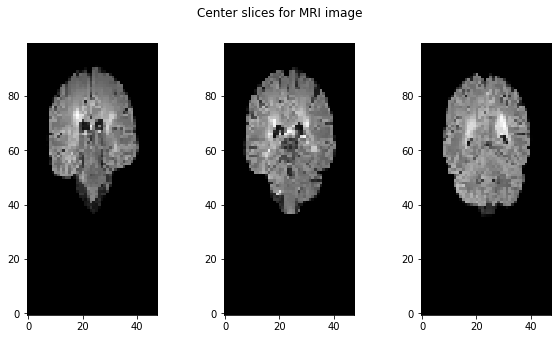

In [82]:
slice_0 = img[:, 60, :]
slice_1 = img[:, 64, :]
slice_2 = img[:, 70, :]
show_slices([slice_0, slice_1, slice_2])
plt.suptitle("Center slices for MRI image")

Text(0.5, 0.98, 'Center slices for MRI image segmented by prediction')

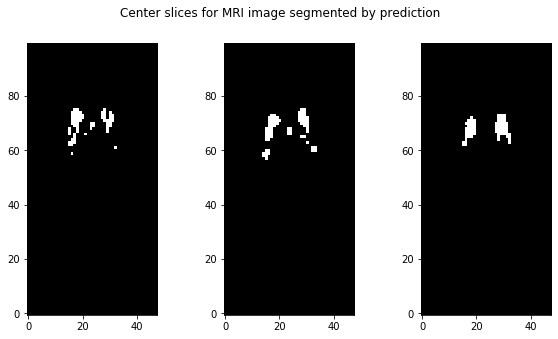

In [83]:
slice_0 = img_seg[:, 60, :]
slice_1 = img_seg[:, 64, :]
slice_2 = img_seg[:, 70, :]
show_slices([slice_0, slice_1, slice_2])
plt.suptitle("Center slices for MRI image segmented by prediction")

Text(0.5, 0.98, 'Center slices for MRI image segmented original')

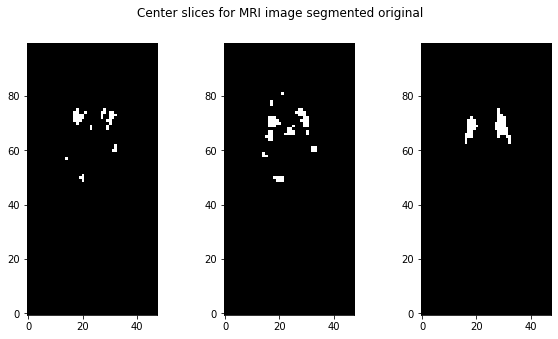

In [84]:
slice_0 = img_seg_original[:, 60, :]
slice_1 = img_seg_original[:, 64, :]
slice_2 = img_seg_original[:, 70, :]
show_slices([slice_0, slice_1, slice_2])
plt.suptitle("Center slices for MRI image segmented original")

In [86]:
print(img_seg_original.shape, np.sum(img_seg_original), np.amax(img_seg_original))
print(img_seg.shape, np.sum(img_seg), np.amax(img_seg))
print(img.shape, np.sum(img), np.amax(img))
print(1-dice_loss(torch.from_numpy(img_seg.flatten()), torch.from_numpy(img_seg_original.flatten())))
print(val_img_mask_paths)

(48, 100, 100) 1551.0 1.0
(48, 100, 100) 2030.0 1.0
(48, 100, 100) 24228.988 1.0
tensor(0.5219)
[('data/Pre-processed training dataset\\07043SEME\\FLAIR_preprocessed.nii.gz', 'data/TrainingDataset_MSSEG\\07043SEME\\Consensus.nii.gz'), ('data/Pre-processed training dataset\\08002CHJE\\FLAIR_preprocessed.nii.gz', 'data/TrainingDataset_MSSEG\\08002CHJE\\Consensus.nii.gz'), ('data/Pre-processed training dataset\\08027SYBR\\FLAIR_preprocessed.nii.gz', 'data/TrainingDataset_MSSEG\\08027SYBR\\Consensus.nii.gz'), ('data/Pre-processed training dataset\\08029IVDI\\FLAIR_preprocessed.nii.gz', 'data/TrainingDataset_MSSEG\\08029IVDI\\Consensus.nii.gz'), ('data/Pre-processed training dataset\\08031SEVE\\FLAIR_preprocessed.nii.gz', 'data/TrainingDataset_MSSEG\\08031SEVE\\Consensus.nii.gz'), ('data/Pre-processed training dataset\\08037ROGU\\FLAIR_preprocessed.nii.gz', 'data/TrainingDataset_MSSEG\\08037ROGU\\Consensus.nii.gz')]
